# Generating circuity for Atlanta 
(without using Aequilibrae outputs)
1. read in GMNS links and nodes 
2. calculate straight-line distances (convert back to projected coordinates)
3. calculate shortest paths (using igraph -- faster than networkx)
4. calculate circuity and write all to omx file

To-dos:
- avoid routing via centroid connectors (add weight to them)

In [2]:
import sqlite3
import pandas as pd
import geopandas as gpd # must be v0.9+ for GeoSeries.from_wkt()
import os, shutil
import networkx as nx
import numpy as np
import time
import openmatrix as omx
import igraph as ig #pip install python-igraph

os.chdir(r"C:\Users\ian.berg\Documents\gmns_local")
# shutil.copy("processedwzdata.sqlite", "processedwzdata_edit.sqlite")
conn = sqlite3.connect("ATL.sqlite")
c = conn.cursor()

In [5]:
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = c.fetchall()
tables

[('spatial_ref_sys',),
 ('spatialite_history',),
 ('sqlite_sequence',),
 ('geometry_columns',),
 ('spatial_ref_sys_aux',),
 ('views_geometry_columns',),
 ('virts_geometry_columns',),
 ('geometry_columns_statistics',),
 ('views_geometry_columns_statistics',),
 ('virts_geometry_columns_statistics',),
 ('geometry_columns_field_infos',),
 ('views_geometry_columns_field_infos',),
 ('virts_geometry_columns_field_infos',),
 ('geometry_columns_time',),
 ('geometry_columns_auth',),
 ('views_geometry_columns_auth',),
 ('virts_geometry_columns_auth',),
 ('data_licenses',),
 ('sql_statements_log',),
 ('modes',),
 ('idx_links_geometry_rowid',),
 ('idx_links_geometry_node',),
 ('idx_links_geometry_parent',),
 ('idx_nodes_geometry_rowid',),
 ('idx_nodes_geometry_node',),
 ('idx_nodes_geometry_parent',),
 ('nodes',),
 ('links',),
 ('SpatialIndex',),
 ('ElementaryGeometries',),
 ('KNN',),
 ('idx_links_geometry',),
 ('idx_nodes_geometry',),
 ('GMNS_node_backup',),
 ('GMNS_node',),
 ('GMNS_link',)]

In [6]:
df_links = pd.read_sql_query("select * from gmns_link", conn)
df_nodes = pd.read_sql_query("select * from gmns_node", conn)

df_nodes = df_nodes.set_index('node_id', drop=False)
df_links = df_links.set_index('link_id', drop=False)

# get centroids
df_taz = df_nodes[df_nodes["node_type"] == "centroid"]
tazdictrow = {}
for index in df_taz.index:
    #DEBUG print(index, df_node['node_id'][index], df_node['node_type'][index])
    tazdictrow[df_taz['node_id'][index]]=index
taz_list = list(tazdictrow.keys())
matrix_size = len(tazdictrow)   #Matches the number of nodes flagged as centroids
print(matrix_size)   #DEBUG
highest_centroid_node_number = max(tazdictrow, key=tazdictrow.get)  #for future use
print(highest_centroid_node_number)  #DEBUG


6031
6031


## generating matrices
now if you just want to look at the results you can skip to [using the results](#using-the-results). 
the next several cells generate straight line, shortest path, and circuity matrices.

In [4]:
# calculate sl distances
gdf_taz = gpd.GeoDataFrame(df_taz, geometry=gpd.points_from_xy(df_taz["x_coord"], df_taz["y_coord"]), crs=4326) # 4326=WGS84
gdf_taz = gdf_taz.to_crs(2240) # Georgia State Plane West (feet)

# using GeoSeries can calculate all to-nodes from a single from-node at once
def sl_dists_mi(a):
    pt_a = gdf_taz.loc[a].geometry
    bs = gdf_taz.geometry
    return bs.distance(pt_a) / 5280

start_time = time.time()
df = pd.DataFrame(columns=taz_list)
for row in taz_list:
    dfrow = sl_dists_mi(row)
    df = df.append(dfrow, ignore_index=True)
    if row % 1000 == 0: 
        print(row)
print(time.time() - start_time)
# about 10 minutes
# probably could be faster since this is symmetric

1000
2000
3000
4000
5000
6000
598.652843952179


In [5]:
# write sl distances to matrix
outfile = os.path.join(os.getcwd() ,'circuity_ib.omx')

f_output = omx.open_file(outfile,'w')
f_output.create_mapping('taz',taz_list)
sl_array = df.to_numpy()
f_output['sl_matrix'] = sl_array
#f_output.close()


In [25]:
# optional step, recalculate link lengths for shortest path
# (the df_links length field matches closely with the output but it had some zero values present

gdf_links = gpd.GeoDataFrame(df_links, geometry=gpd.GeoSeries.from_wkt(df_links['geometry']), crs=4326)
gdf_links = gdf_links.to_crs(2240)
gdf_links["len_new"] = gdf_links["geometry"].length / 5280


In [26]:
# for igraph: need from and to nodes to be first two cols
# just pulling what we need for sp
df_ig_e = gdf_links[["from_node_id", "to_node_id", "link_id", "length", "len_new"]] 
df_ig_n = df_nodes[["node_id", "name", "x_coord", "y_coord"]]

# igraph node IDs are autogenerated, can't choose them, but if they have a name attribute we can use those instead
# use strs to avoid confusion with the auto-assigned int ids
df_ig_n = df_ig_n.assign(name = df_ig_n["node_id"].astype(str))
g = ig.Graph.DataFrame(df_ig_e, directed=True, vertices=df_ig_n)


In [7]:
start_time = time.time()
sp_list = g.shortest_paths(taz_list,taz_list,weights="len_new") # now using recalculated lengths
print(time.time() - start_time)
# 82 seconds


81.78221893310547


In [8]:
# write sp matrix to omx
sp_array = np.array(sp_list)
#outfile = os.path.join(os.getcwd() ,'circuity.omx')

#f_output = omx.open_file(outfile,'a')
f_output['sp_matrix'] = sp_array
#f_output.close()


In [9]:
circuity = sp_array/sl_array
circuity = np.nan_to_num(circuity, nan=1.0)

#outfile = os.path.join(os.getcwd() ,'circuity.omx')
#f_output = omx.open_file(outfile,'a')
f_output['circuity'] = circuity
f_output.close()

C:\Users\ian.berg\AppData\Local\Continuum\anaconda3\envs\wrangler_env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


## using the results


In [3]:
# read existing files
infile = os.path.join(os.getcwd() ,'circuity_2021-05-11.omx')
f_input = omx.open_file(infile,'r')
circuity = np.array(f_input['circuity'])
sp_array = np.array(f_input['sp_matrix'])
sl_array = np.array(f_input['sl_matrix'])
f_input.close()

In [24]:
# checking summmary of results,
# first where circuity is less than 1
print(len(np.argwhere(circuity<1))/(matrix_size**2)) 
print(np.argwhere(circuity<1)) # 693,694 and vv
circuity[np.where(circuity<1)] # 0.9999986, close enough

5.4985900103101315e-08
[[693 694]
 [694 693]]


array([0.99999862, 0.99999862])

In [16]:
# now where circuity > 2
print(len(np.argwhere(circuity>2))/(matrix_size**2)) #0.0007 fraction of values
np.argwhere(circuity>2)

0.0007309275700705258


array([[   0, 4141],
       [   0, 4146],
       [   0, 4147],
       ...,
       [6030, 6027],
       [6030, 6028],
       [6030, 6029]], dtype=int64)

[[6002 6003]]
[45.89242699]


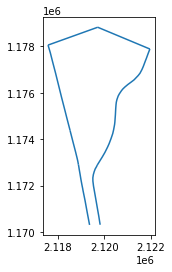

In [30]:
# investigate the max
# need the graph and gdf to be generated for this step
print(np.argwhere(circuity == np.max(circuity)))
print(circuity[np.where(circuity == np.max(circuity))])
from_node_id = str(taz_list[6002])
to_node_id = str(taz_list[6003])

sp_edge_ids = g.get_shortest_paths(from_node_id,to_node_id,weights="len_new",output="epath")[0]
sp_link_ids = g.es[sp_edge_ids].get_attribute_values("link_id")
sp_links = gdf_links.loc[sp_link_ids]
sp_links.plot()

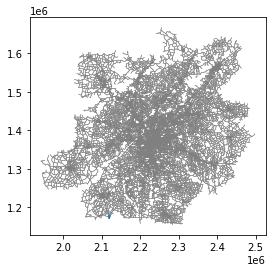

In [33]:
base = gdf_links.plot(lw=0.5, color="grey")
sp_links.plot(ax=base)
# hard to see but it's at the very edge of the network

In [ ]:
'''
#below this line was my first attempt using networkx
#which is slower than igraph 
#https://graph-tool.skewed.de/performance

G = nx.from_pandas_edgelist(df_links, 'from_node_id', 'to_node_id', True, nx.MultiDiGraph)

for i in G.nodes():
    try:
        G.nodes[i]['x_coord'] = df_nodes.x_coord[i]
        G.nodes[i]['y_coord'] = df_nodes.y_coord[i]
        G.nodes[i]['pos'] = (G.nodes[i]['x_coord'],G.nodes[i]['y_coord']) # for drawing
        G.nodes[i]['node_type'] = df_nodes.node_type[i]  # could be used in future to filter out "fatal" issues
                                                    # e.g. path exists to an external node that only has inbound travel lanes
    except:
        print(i," not on node list")
        
#%%
def sp_dists_mi(a):
    taz_series = pd.Series(taz_list)
    return taz_series.apply(lambda x: nx.shortest_path_length(G,a,x, weight= "length"))

# try just one row
start_time = time.time()
row = sp_dists_mi(1)
print(time.time() - start_time)
# took 15min for one row => 62 days to finish all
'''